running eazy automatically

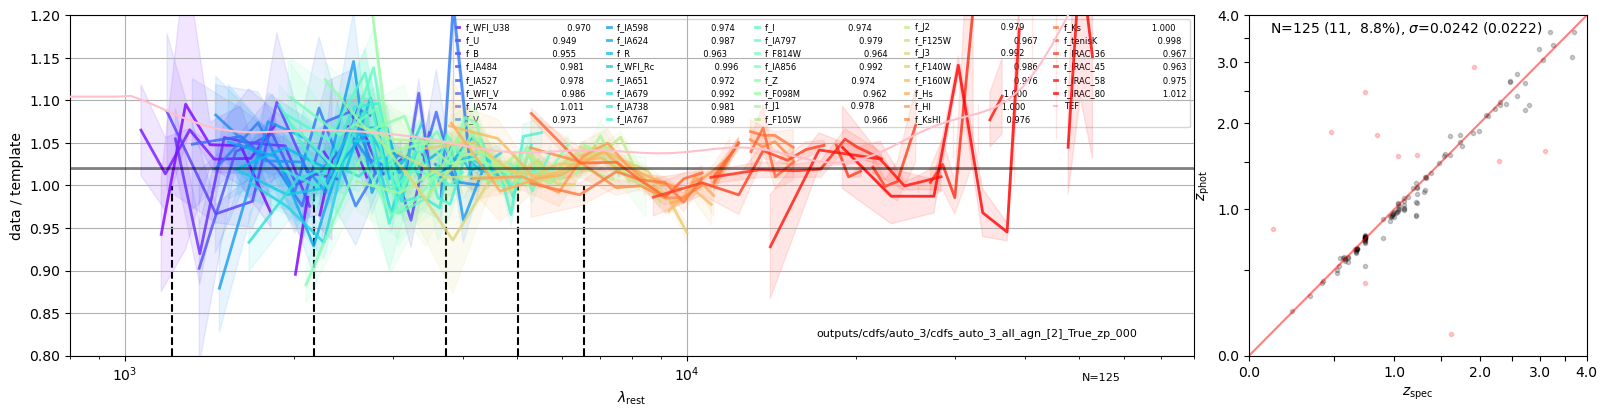

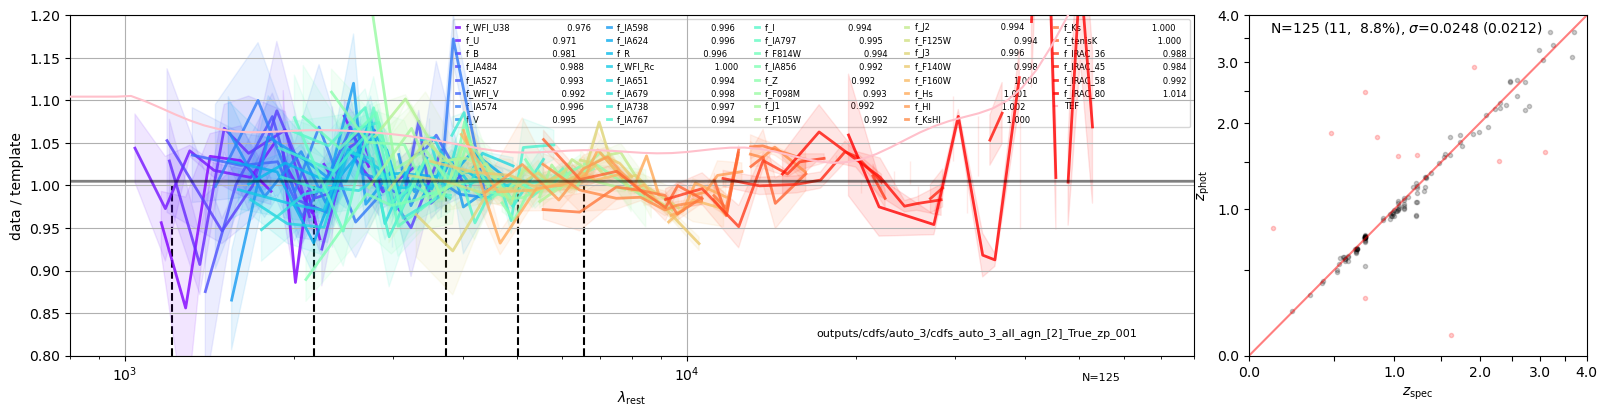

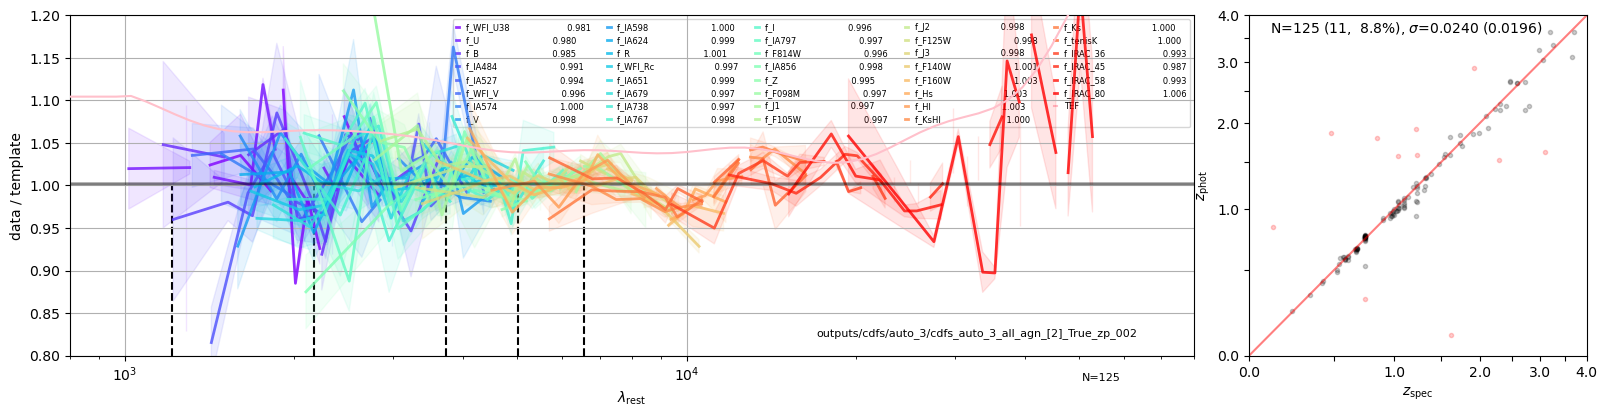

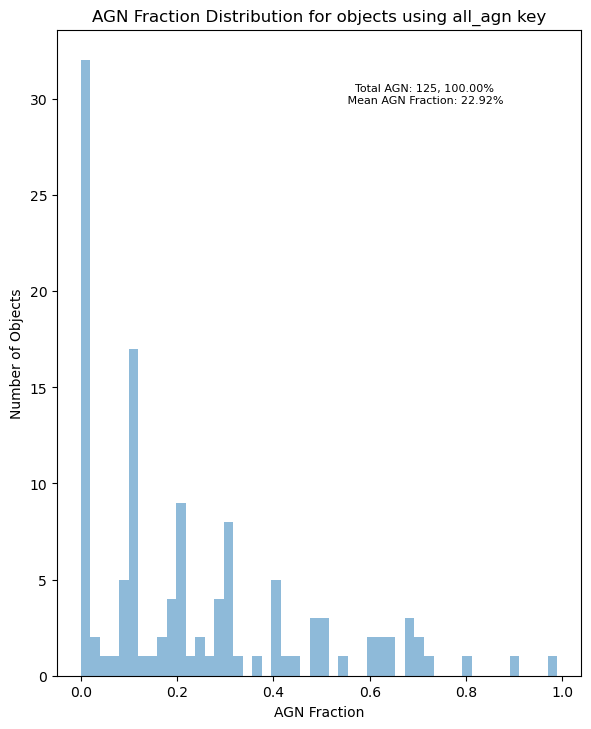

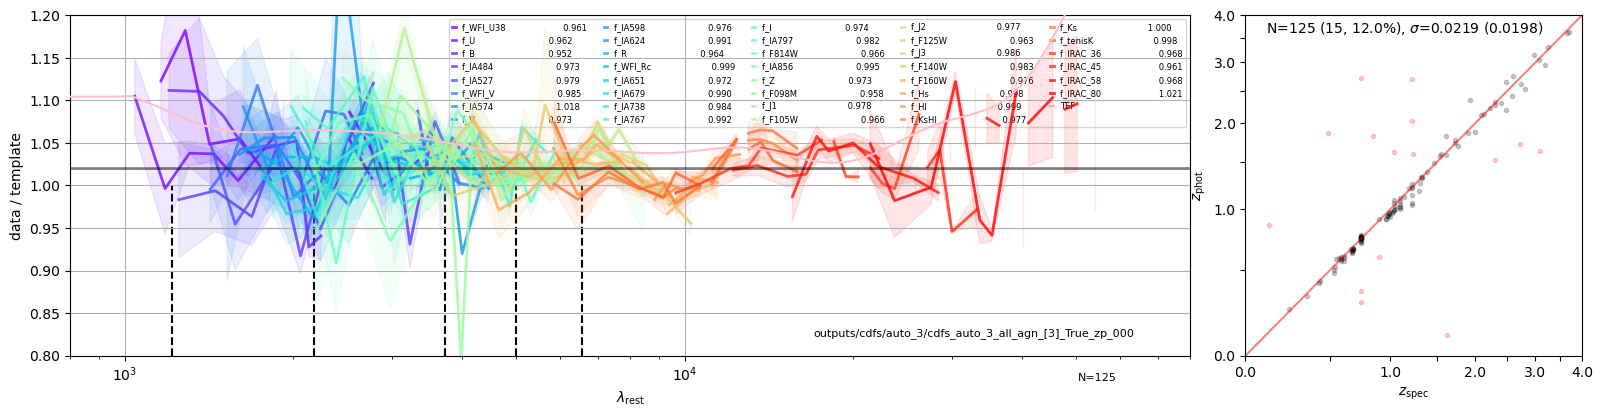

Error in callback <function flush_figures at 0x000002896BD8F2E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [1]:
# Running through the Eazy_test.ipynb notebook automatically
# ------------------------------------------------------------

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import time
import importlib
import sys
import eazy
import astropy.stats

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

os.getcwd()

# Load ZFOURGE catalogue from local drive
test_title = 'auto_3' # title of the test
field = 'cdfs' #'cdfs', 'cosmos', or 'uds'

# A key designates what type of test you want to occur
id_key = 'all_agn' # normal, high or low

# Choose ID key for the catalogue (chosen in loop)
# Directories for key, name key's anything, it is just to keep track of any complex object choices
id_key_dict = {'normal': 'inputs/alternate_catalogues/cdfs.(0, -1).range.cat',
                 'high': 'inputs/alternate_catalogues/cdfs.(18000, 20000).range.cat',
                  'low': 'inputs/alternate_catalogues/cdfs.(6000, 10000).range.cat',
              'all_agn': f'inputs/alternate_catalogues/{field}.all_agn.cat',
               'no_agn': f'inputs/alternate_catalogues/{field}.no_agn.cat',
               'ir_agn': f'inputs/alternate_catalogues/{field}.ir_agn.cat',
            'radio_agn': f'inputs/alternate_catalogues/{field}.radio_agn.cat',
             'xray_agn': f'inputs/alternate_catalogues/{field}.xray_agn.cat'
     'fraction_bin_20' : f'inputs/alternate_catalogues/cdfs.fraction.bin20.cat'}

# AGN templates allocation
use_galaxy_templates = True # set to True to use galaxy templates as well

# Template Maximum

no_of_sets = 2 # number of sets reused and appended to from the old test
template_max = 9 # maximum number of templates to be used

# ------------------------------------------------------------
# Load any templates from the AGN template library

temp_param = 'templates/eazy_v1.3.spectra.param'  # basic parameter file, no agn templates
last_id = 9  # last id in the parameter file
empty_param = 'templates/eazy_v1.3_empty.param'  # empty parameter file

agn_param = 'templates/eazy_v1.3_AGN.param'  # parameter file with agn templates

# opening the parameter files, and reading the contents
with open(temp_param) as f:
    original_galaxy = f.read()

with open(empty_param) as f:
    original_empty = f.read()

agn_dir = 'templates/hlsp_agnsedatlas_observed/'  # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)
# ------------------------------------------------------------
def agn_template_loader(templates, use_galaxy_templates=False):
    """
    Function to load AGN templates to the parameter file
    templates: list of templates to be added
    use_galaxy_templates: set to True to use galaxy templates as well
    """
    if use_galaxy_templates:
        copy = original_galaxy
        no_of_templates = len(templates)
        if no_of_templates == 0:
            open(agn_param, 'w').write(copy)
            print('No AGN templates added, just using galaxy templates')
            return
        for i in range(no_of_templates):
            id = last_id + i
            copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
        open(agn_param, 'w').write(copy)
        print(f'AGN templates added to the parameter file {agn_param}, {last_id} galaxy templates used')
        return
    else:
        copy = original_empty
        no_of_templates = len(templates)
        if no_of_templates == 0:
            open(agn_param, 'w').write(copy)
            print('No AGN templates added, no templates used')
            return
        for i in range(no_of_templates):
            id = 0 + i
            copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
        open(agn_param, 'w').write(copy)
        print(f'AGN templates added to the parameter file {agn_param}, no galaxy templates used')
        return
# ------------------------------------------------------------
# function to get best templates

def best_templates(data, key, loop_no, no_of_sets):
    """
    Function to get the best templates from the key_data.csv file of an old test
    data: key_data.csv file of the old test
    test_name: name of the test
    key: key of the test
    loop_no: loop number of the test, should be one less than the current loop number
    no_of_sets: number of sets of templates to be returned
    """

    os.getcwd()
    old_results = data

    old_results = old_results[old_results['id_key'] == key]
    old_results = old_results[old_results['loop_number'] == loop_no]
    old_results = old_results.sort_values(by='nmad_val')
    old_results =  old_results['agn_templates']
    old_results_final = old_results.head(no_of_sets)

    return old_results_final.reset_index(drop=True)
# ------------------------------------------------------------
# finding/creating the output directories

# Directories
if not os.path.isdir(f'outputs/{field}/{test_title}'):
    os.makedirs(f'outputs/{field}/{test_title}')

# Where to Save number data
key_data_file = f'outputs/{field}/{test_title}/key_data.csv'
headings = ['id_key', 'loop_number', 'agn_templates', 'galaxy templates', 'total_obj', 'total_agn', 'total_agn_percent', 'ir_count', 'ir_percent', 'radio_count', 'radio_percent', 'xray_count', 'xray_percent', 'mean_agn_frac', 'count', 'outlier_count', 'nmad_val', 'all_nmad_bin']

key_data = pd.DataFrame(columns=headings)
key_index = 0

if not os.path.isfile(key_data_file):
    key_data.to_csv(key_data_file, index=False)

# Reading the AGN data
agn_per_dir = 'inputs/cdfs_agn_frac.txt' # THIS IS JUST CDFS
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

# Begin Loop

for temp_set_length in range(template_max):
    loop_number = temp_set_length

    if temp_set_length == 0:
        forward_set = 1
    else:
        forward_set = no_of_sets

    old_templates = best_templates(data=key_data, key=id_key, loop_no=loop_number-1, no_of_sets=no_of_sets)

    if old_templates.duplicated().any():
        print('Duplicate template found, Test over')
        break

    for old_set in range(forward_set):
            if temp_set_length == 0:
                old_templates_forward = []
            else:
                old_templates_forward = old_templates[old_set]

            for template_forward in range(len(agn_temp_all)):
                agn_sed = old_templates_forward + [template_forward]
                print(f'Running with {agn_sed}')

                output_directory = f'outputs/{field}/{test_title}/{field}_{test_title}_{id_key}_{agn_sed}_{use_galaxy_templates}'  # output directory for images, all values for field go to key

                # making an agn catalogue with only selected range of objects

                main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
                main_cat.to_csv('inputs/eazy_test.cat', index=False) # create a new catalogue, allows for change to be made in this cell


                main = pd.read_csv('inputs/eazy_test.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
                headers = pd.read_csv('inputs/eazy_test.cat', sep=" ", header=None, nrows=1).iloc[0]
                headers = headers[1:]
                main.columns = headers

                total_count = len(main) # all objects in the range

                # total count
                all_agn = main[(main['ir_agn'] == 1) | (main['radio_agn'] == 1) | (main['xray_agn'] == 1)]
                total_agn = len(all_agn) # all objects in the range that are AGN

                ir_count = main['ir_agn'].value_counts().get(1, 0)
                ir_percent = ir_count/total_agn
                radio_count = main['radio_agn'].value_counts().get(1, 0)
                radio_percent = radio_count/total_agn
                xray_count = main['xray_agn'].value_counts().get(1, 0)
                xray_percent = xray_count/total_agn

                agn_frac = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object
                mean_frac = np.mean(agn_frac['bayes.agn.fracAGN'])

                plt.clf()
                plt.hist(agn_frac['bayes.agn.fracAGN'], bins=50, alpha=0.5, label='AGN Fraction')

                plt.xlabel('AGN Fraction')
                plt.ylabel('Number of Objects')
                plt.title(f'AGN Fraction Distribution for objects using {id_key} key')
                plt.text(0.7,0.9, f'Total AGN: {total_agn}, {total_agn/total_count:.2%}\n '
                          f'Mean AGN Fraction: {mean_frac:.2%}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.savefig(f'outputs/{field}/{test_title}/agn_frac_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')

                # EAZY parameters

                # following files should be in the same dir as the project
                param_file = f'base.param' #base parameter file, does not include all information
                translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

                agn_template_loader(agn_sed, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

                params = {} # setting field specific parameters
                params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit

                #inputs
                params['TEMPLATES_FILE'] = 'templates/eazy_v1.3_AGN.param' # parameter file containing which templates will be used
                params['CACHE_FILE'] = f'zfourge/{field}/{field}.tempfilt'
                params['CATALOG_FILE'] = 'inputs/eazy_test.cat' # for cut catalogue created in the earlier cell

                #outputs
                params['MAIN_OUTPUT_FILE'] = output_directory # output directory set earliet

                # Run EAZY with parameters

                self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                                         params=params, load_prior=True, load_products=False)

                # Iterative Zero-point corrections

                NITER = 3 # no. of iterations
                NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

                for iter in range(NITER):

                    sn = self.fnu/self.efnu
                    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
                    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                                              update_zeropoints=True, iter=iter, n_proc=8,
                                              save_templates=False, error_residuals=False,
                                              NBIN=NBIN, get_spatial_offset=False)

                # Turn off error corrections derived above
                self.set_sys_err(positive=True)

                # Full catalog
                sample = np.isfinite(self.ZSPEC)

                # fit_parallel renamed to fit_catalog 14 May 2021
                self.fit_catalog(self.idx[sample], n_proc=8)

                # Show zspec-zphot comparison
                fig = self.zphot_zspec(zmax = 8)
                fig.savefig(f'outputs/{field}/{test_title}/zphot_zspec_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')

                # NMAD calculation and plot

                combined = list(zip(self.ZSPEC, self.zbest))
                filtered = [(x, y) for x, y in combined if x > 0.005 and y > 0.02]
                sorted_filtered = sorted(filtered, key=lambda x: x[0])
                zspec_sorted, zphot_sorted = zip(*sorted_filtered)

                #total NMAD
                dz = (np.array(zphot_sorted) - np.array(zspec_sorted)) / (1 + np.array(zspec_sorted))
                total_nmad = astropy.stats.mad_std(dz)

                #outliers
                cat_count = len(dz)
                outliers = np.abs(dz) >= 0.15 # 0.15 is catostrophic_outlier in eazy code
                outliers_count = sum(outliers)

                no_of_bins = 15 # no. of bins

                logbins_start = np.log10(min(zspec_sorted)) # using logarithmic bins
                logbins_end = np.log10(max(zspec_sorted)) + 1e-10 # adding a small value to include the last value
                logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
                counts, bins = np.histogram(zspec_sorted, bins=logbins)


                last_val = 0
                nmad_val = []
                for bin in range(no_of_bins):
                    new_val = last_val + counts[bin]-1
                    zspec_val = zspec_sorted[last_val:new_val]
                    zphot_val = zphot_sorted[last_val:new_val]
                    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
                    nmad_val.append(astropy.stats.mad_std(dz))
                    last_val = new_val + 1

                bin_centers = (np.array(bins[:-1]) + np.array(bins[1:])) / 2
                plt.clf()
                plt.plot(bin_centers, nmad_val, 'r--')  # 'r--' specifies a red dashed line

                plt.xlabel('Redshift')
                plt.ylabel('NMAD Value')

                plt.title('NMAD against Redshift')

                plt.savefig(f'outputs/{field}/{test_title}/nmad_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')

                # Saving Key data to csv

                key_data.loc[key_index] = [id_key, loop_number, agn_sed, use_galaxy_templates, total_count, total_agn, total_agn/total_count, ir_count,        ir_percent, radio_count,radio_percent, xray_count, xray_percent, mean_frac, cat_count, outliers_count, total_nmad, nmad_val]
                key_index += 1


# that's all folks

In [2]:
key_data.to_csv(key_data_file, mode='a', index=False, header=True)

# that's all folks

In [3]:
import pandas as pd
df = pd.DataFrame([1,2,3,4],
                  [3,4,5,6],
                  [1,2,3,4])
print(df)

ValueError: Shape of passed values is (4, 1), indices imply (4, 4)

In [ ]:
if df.duplicated().any():
        print('Duplicate template found, Test over')